In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.covariance import GraphicalLasso, GraphicalLassoCV
from scipy import stats
from matplotlib.colors import ListedColormap

import os
from dotenv import load_dotenv
os.chdir("..")

load_dotenv("globs.env")
tickers   = os.getenv("TICKERS").split(",")
media_dir = os.getenv("MEDIA_DIR")
data_dir  = os.getenv("DATA_DIR")

In [2]:
## Load data
X_df = pd.read_csv(data_dir + "/returns.csv").set_index("date").ffill() # handle NaN
X = StandardScaler().fit_transform(X_df.values)
n, p = X.shape
print(f"n x p:", (n, p))

n x p: (1222, 15)


### Part B

#### Gaussian Graphical Lasso

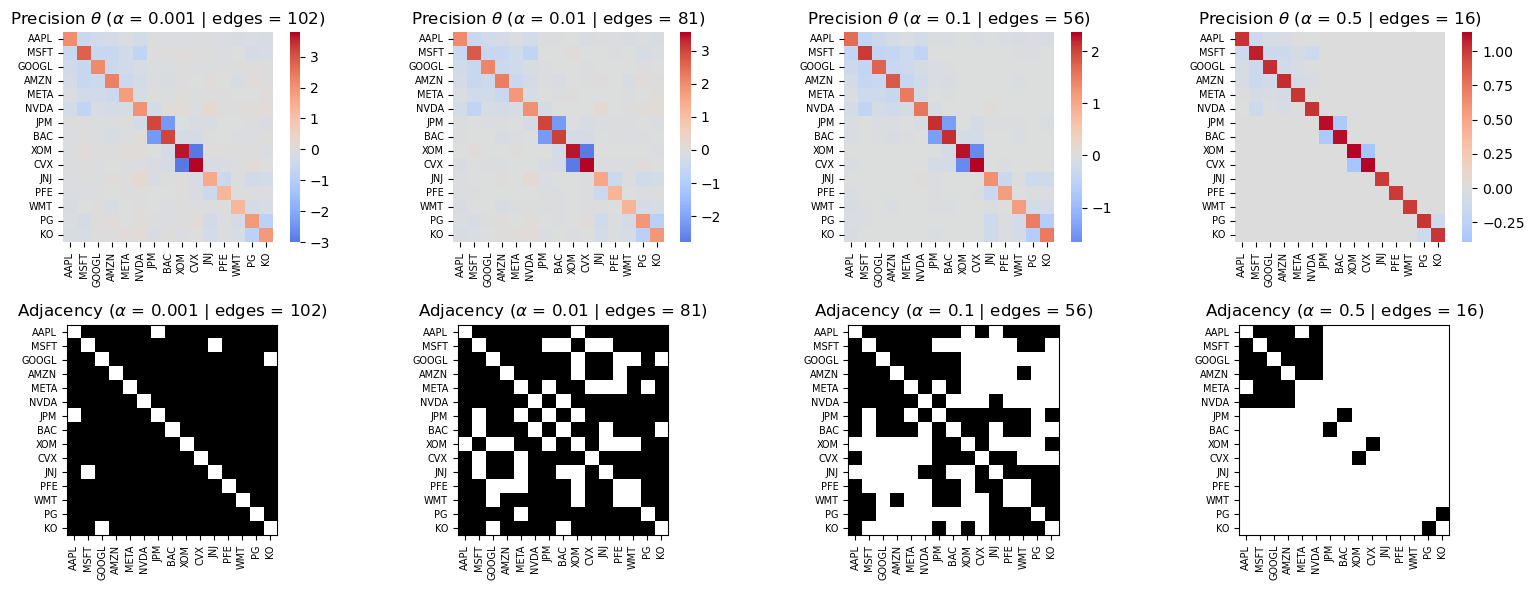

In [3]:
def run_gl_across_grid(savepath = None):
    alphas = [0.001, 0.01, 0.1, 0.5]
    thetas, adjs, titles = [], [], []

    eps = 1e-6

    for a in alphas:
        gl = GraphicalLasso(alpha=a, max_iter=2000)
        gl.fit(X)
        Theta = gl.precision_

        A = (np.abs(Theta) > eps).astype(int)
        np.fill_diagonal(A, 0)

        thetas.append(Theta)
        adjs.append(A)

        edges = int(np.sum(np.triu(A, 1)))
        titles.append(rf"$\alpha$ = {a:g} | edges = {edges}")

    fig, axes = plt.subplots(2, len(alphas), figsize=(4 * len(alphas), 6))
    cmap_bw = ListedColormap(["white", "black"])

    for i, (Theta, A, ttl) in enumerate(zip(thetas, adjs, titles)):
        # Precision heatmap
        sns.heatmap(
            Theta, center=0, cmap="coolwarm", square=True,
            xticklabels=tickers, yticklabels=tickers,
            cbar_kws={"shrink": 1},
            ax=axes[0, i]
        )
        axes[0, i].set_title(rf"Precision $\theta$ ({ttl})")
        axes[0, i].tick_params(labelsize=7)
        for t in axes[0, i].get_xticklabels(): t.set_rotation(90)

        # adjacency
        axes[1, i].imshow(A, cmap=cmap_bw, vmin=0, vmax=1)
        axes[1, i].set_title(f"Adjacency ({ttl})")
        axes[1, i].set_xticks(range(p)); axes[1, i].set_yticks(range(p))
        axes[1, i].set_xticklabels(tickers, rotation=90, fontsize=7)
        axes[1, i].set_yticklabels(tickers, fontsize=7)

    plt.tight_layout()
    if savepath:
        plt.savefig(savepath)
    plt.show()

run_gl_across_grid(media_dir + "/graphicalLASSO_precision_across_alpha.png")

Chosen alpha (CV): 0.0206792


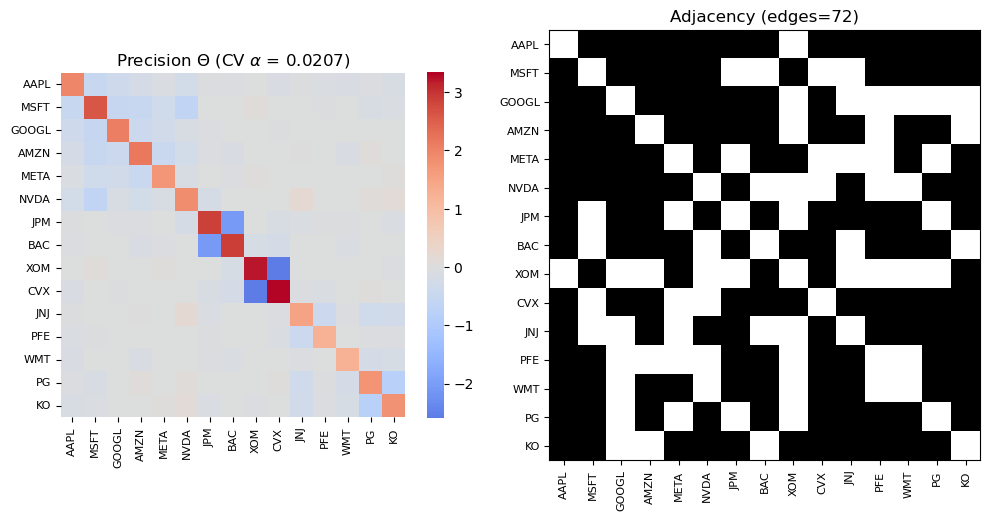

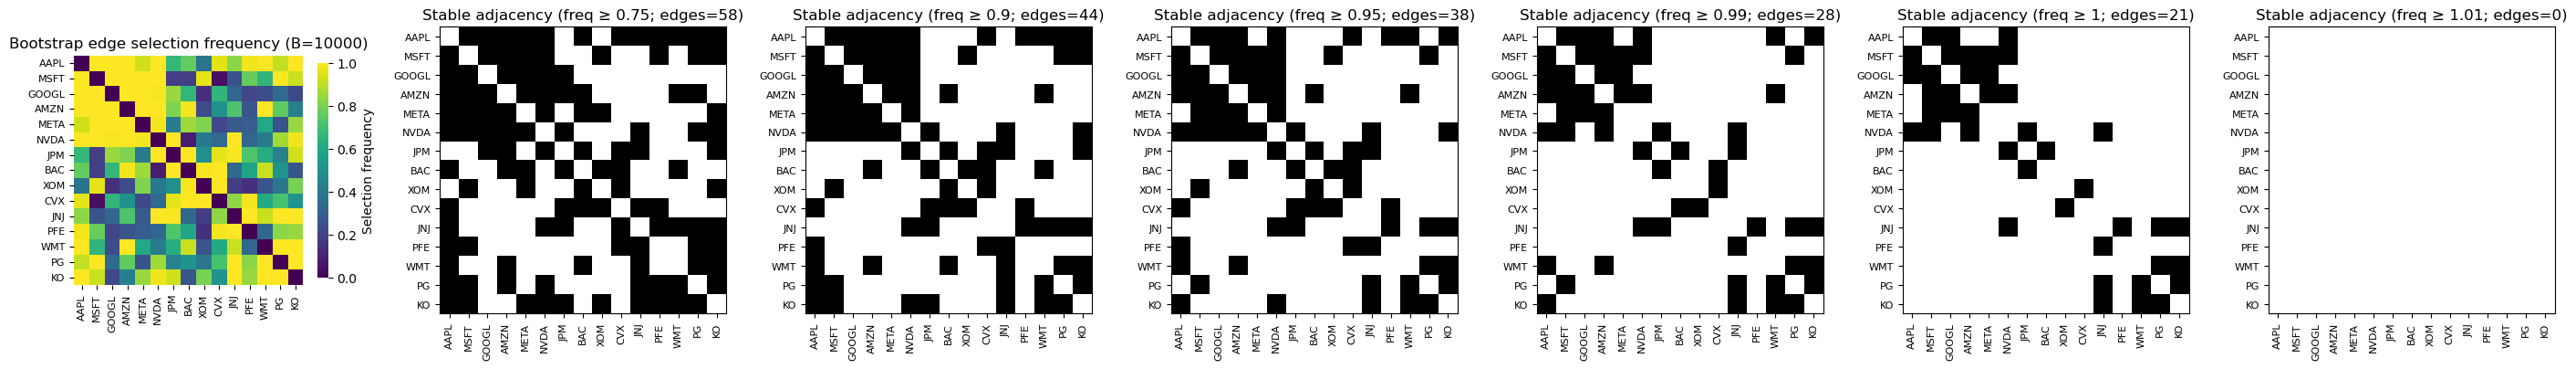

In [4]:
def graphicalLASSO_hyperparameter_tuning(X, savepath1 = None, savepath2 = None):
    # Fit Graphical Lasso with CV to get alpha_star
    glcv = GraphicalLassoCV(alphas=10, cv=5, max_iter=1000).fit(X)
    Theta = glcv.precision_
    alpha_star = glcv.alpha_
    print(f"Chosen alpha (CV): {alpha_star:.6g}")

    # Build adjacency from CV precision
    eps = 1e-6
    A = (np.abs(Theta) > eps).astype(int)
    np.fill_diagonal(A, 0)
    A = np.maximum(A, A.T)
    edges = int(np.sum(np.triu(A, 1)))

    # Plot precision + adjacency
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # (A) Precision
    sns.heatmap(
        Theta, center=0, cmap="coolwarm", square=True,
        xticklabels=tickers, yticklabels=tickers,
        cbar_kws={"shrink": 0.8},
        ax=axes[0]
    )
    axes[0].set_title(rf"Precision $\Theta$ (CV $\alpha$ = {alpha_star:.3g})", fontsize=12)
    axes[0].tick_params(labelsize=8)
    for t in axes[0].get_xticklabels(): t.set_rotation(90)

    # (B) Adjacency
    axes[1].imshow(A, cmap=ListedColormap(["white", "black"]), vmin=0, vmax=1)
    axes[1].set_title(f"Adjacency (edges={edges})", fontsize=12)
    axes[1].set_xticks(range(len(tickers)))
    axes[1].set_yticks(range(len(tickers)))
    axes[1].set_xticklabels(tickers, rotation=90, fontsize=8)
    axes[1].set_yticklabels(tickers, fontsize=8)

    plt.tight_layout()
    if savepath1: plt.savefig(savepath1)
    plt.show()

    # Stability Selection with fixed alpha_star
    B = 10_000
    rng = np.random.RandomState(42)
    n, p = X.shape
    eps = 1e-8

    sel_counts = np.zeros((p, p), dtype=float)

    for b in range(B):
        idx = rng.randint(0, n, size=n)
        Xb = X[idx]

        gl = GraphicalLasso(alpha=alpha_star, max_iter=1000, tol=5e-3)
        gl.fit(Xb)
        Theta_b = gl.precision_

        A_b = (np.abs(Theta_b) > eps).astype(int)
        np.fill_diagonal(A_b, 0)
        A_b = np.maximum(A_b, A_b.T)

        sel_counts += A_b

    freq = sel_counts / B
    np.fill_diagonal(freq, 0.0)

    # Threshold frequencies
    thr_list = [0.75, 0.90, 0.95, 0.99, 1, 1.01]
    m = len(thr_list) + 1
    A_thr = []
    edge_counts = []

    for thr in thr_list:
        A = (freq >= thr).astype(int)
        np.fill_diagonal(A, 0)
        A = np.maximum(A, A.T)
        A_thr.append(A)
        edge_counts.append(int(np.sum(np.triu(A, 1))))

    # Plot stability results
    fig, axes = plt.subplots(1, m, figsize=(4*m, 5))
    cmap_bw = ListedColormap(["white", "black"])

    # Plot the selection frequency heatmap
    sns.heatmap(
        freq, vmin=0, vmax=1, cmap="viridis", square=True,
        xticklabels=tickers, yticklabels=tickers,
        cbar_kws={"shrink": 0.5, "label": "Selection frequency"},
        ax=axes[0]
    )
    axes[0].set_title(f"Bootstrap edge selection frequency (B={B})")
    axes[0].tick_params(labelsize=8)
    for t in axes[0].get_xticklabels():
        t.set_rotation(90)

    for i, (thr, A_mat, ecount) in enumerate(zip(thr_list, A_thr, edge_counts), start=1):
        ax = axes[i]
        ax.imshow(A_mat, cmap=cmap_bw, vmin=0, vmax=1)
        ax.set_title(f"Stable adjacency (freq ≥ {thr}; edges={ecount})")
        ax.set_xticks(range(p))
        ax.set_yticks(range(p))
        ax.set_xticklabels(tickers, rotation=90, fontsize=8)
        ax.set_yticklabels(tickers, fontsize=8)

    plt.tight_layout()
    if savepath2: plt.savefig(savepath2)
    plt.show()

    return glcv

glcv = graphicalLASSO_hyperparameter_tuning(
    X = X,
    savepath1 = media_dir + "/graphicalLASSO_CV.png", 
    savepath2 = media_dir + "/graphicalLASSO_tuning.png"
)

### Nonparanormal Graphical Model

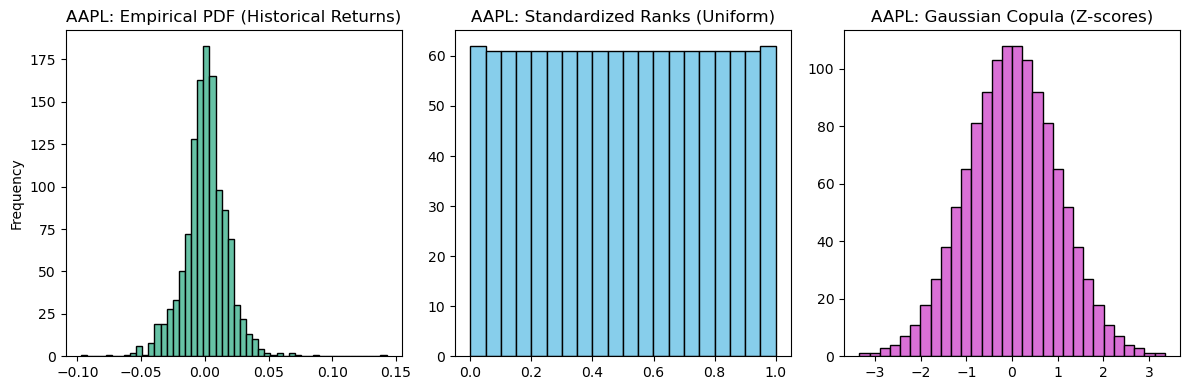

In [5]:
# Demo transform
def demo_copula_transform(ticker="AAPL", savepath=None):
    X = X_df[[ticker]].copy()
    ranks = stats.rankdata(X[ticker].values, method="average") # ranks
    u = (ranks - 0.5) / len(ranks) # standardized ranks in (0,1)
    z = stats.norm.ppf(u) # Gaussian copula transform

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    # Sample histogram ---
    ax[0].hist(X[ticker], bins=50, color= "#66c2a5", edgecolor="black")
    ax[0].set_title(f"{ticker}: Empirical PDF (Historical Returns)")
    ax[0].set_ylabel("Frequency")
    # Uniform histogram ---
    ax[1].hist(u, bins=20, color="skyblue", edgecolor="black")
    ax[1].set_title(f"{ticker}: Standardized Ranks (Uniform)")

    # Gaussian histogram ---
    ax[2].hist(z, bins=30, color="orchid", edgecolor="black")
    ax[2].set_title(f"{ticker}: Gaussian Copula (Z-scores)")
    plt.tight_layout()
    if savepath: plt.savefig(savepath)
    plt.show()

demo_copula_transform(savepath=media_dir+"/demo_copula_transform.png")

# Vectorize transform
def gaussian_copula_transform(X):
    Xn = np.zeros_like(X)
    for j in range(X.shape[1]):
        ranks = stats.rankdata(X[:, j], method="average")
        u = (ranks - 0.5) / len(ranks)
        Xn[:, j] = stats.norm.ppf(u)
    return Xn

Chosen alpha (CV): 0.0142788


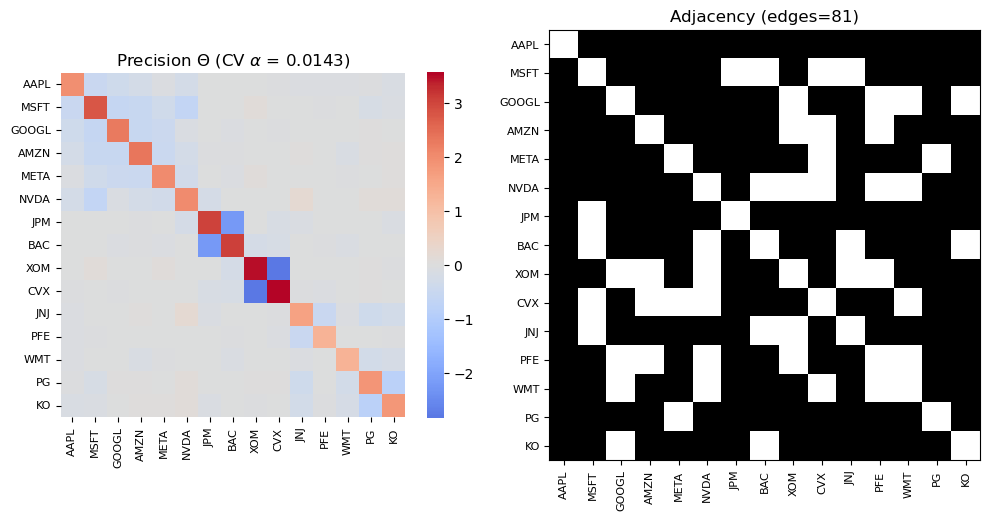

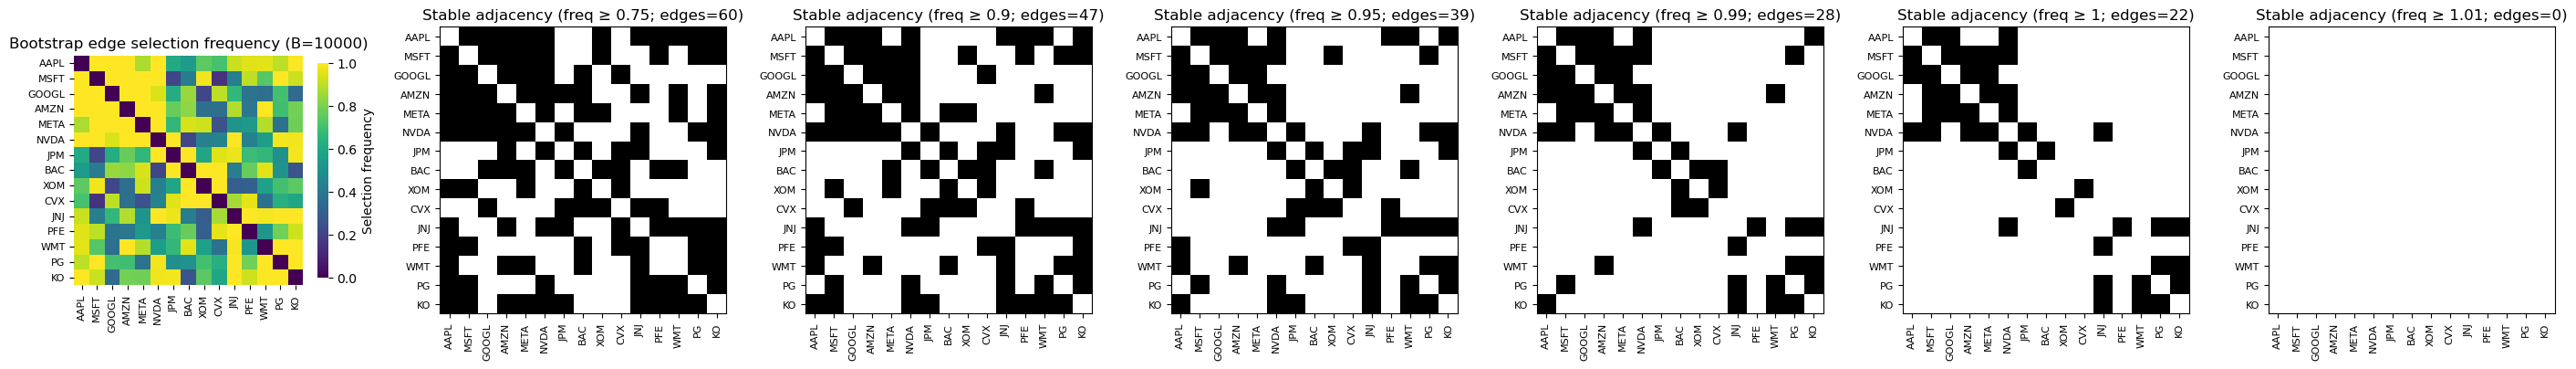

In [6]:
X_gc = gaussian_copula_transform(X_df.values)  # transform original (unscaled) marginals
X_gc = StandardScaler().fit_transform(X_gc)

glcv = graphicalLASSO_hyperparameter_tuning(
    X = X_gc,
    savepath1 = media_dir + "/nonparanormal_CV.png", 
    savepath2 = media_dir + "/nonparanormal_tuning.png"
)